In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from generative_social_choice.plots.jr_and_ejr_eval.baseline_plots.plotting_helper_functions import (
    is_relevant_folder,
    get_agreement_matrix_from_folder_name,
    get_committee_dict_from_folder_name,
    get_agreement_graph_from_folder_name,
    calculate_coverage,
    find_num_cohesive_unsatisfied_agents,
)
from generative_social_choice.plots.plotting_helper_functions import get_graph_path
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from generative_social_choice.utils.helper_functions import (
    get_base_dir_path,
    comment_to_agent_id,
)
from generative_social_choice.objects.agreement_graph import AgreementGraph
from generative_social_choice.objects.agents import DEFAULT_MODEL
import random

random.seed(0)

# Decide which dataset and prompt you want to plot

In [3]:
dataset_name = "changemyview"
query1_prompt_type = "cmv_basic_no_fewshot_yes_cot"
query1_prime_prompt_type = query1_prompt_type
algorithm_type = "JR"
k = 5
seed = 0

# Load data

In [4]:
folders = os.listdir(get_base_dir_path() / "experiments/jr_and_ejr_eval/")

In [5]:
relevant_folders = [
    folder
    for folder in folders
    if is_relevant_folder(
        folder_name=folder,
        dataset_name=dataset_name,
        query1_prompt_type=query1_prompt_type,
        query1_prime_prompt_type=query1_prime_prompt_type,
        algorithm_type=algorithm_type,
        k=k,
        seed=seed,
    )
]
relevant_folders

['2023-08-15-20:22:22__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-21:23:08__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-21:02:49__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-20:04:24__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-21:30:28__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-20:33:22__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-13:50:41__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-21:12:34__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-23:31:26__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-16-00:01:58__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-23:40:53__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '2023-08-15-20:17:20__changemyview__seed_0__JR__cmv_basic_no_fewshot_yes_cot__5',
 '20

In [6]:
len(relevant_folders)

20

In [7]:
llm_1shot_base_dir = get_base_dir_path() / "experiments/llm_1shot/"
folders_1shot = os.listdir(llm_1shot_base_dir)
relevant_1shot_folders = [
    folder
    for folder in folders_1shot
    if is_relevant_folder(
        folder_name=folder,
        dataset_name=dataset_name,
        query1_prompt_type="output_anything",
        query1_prime_prompt_type="output_anything",
        algorithm_type="llm_1_shot",
        k=k,
        seed=seed,
    )
]

In [8]:
len(relevant_1shot_folders)

20

# Process data

In [9]:
results = []
baseline_to_func = {
    "k_random": lambda k: graph.find_k_random_comments(k=k),
    "k_most_popular": lambda k: graph.find_k_most_popular_comments(k=k),
    "JR_on_human_comments": lambda k: graph.find_JR_committee(k=k),
    "process_1": lambda k: list(df.columns)[:k],
}
for folder_name in relevant_folders:
    try:
        folder_id = comment_to_agent_id(folder_name)
        full_df = get_agreement_matrix_from_folder_name(folder_name=folder_name)
        committee = get_committee_dict_from_folder_name(folder_name=folder_name)
        df = full_df[committee.keys()]
        graph = get_agreement_graph_from_folder_name(folder_name=folder_name)
        df_all = pd.concat([df, graph.df], axis=1)
        num_agents = len(df_all.index)
        for k_vary in range(1, k + 1):
            coverage = dict()
            num_cohesive_unsatisfied_agents = dict()
            for baseline, find_committee in baseline_to_func.items():
                comments = find_committee(k_vary)
                coverage = calculate_coverage(df_all=df_all, comments=comments)
                num_cohesive_unsatisfied_agents = find_num_cohesive_unsatisfied_agents(
                    df_all=df_all, comments=comments
                )
                is_jr_violation = int(
                    num_cohesive_unsatisfied_agents >= num_agents / k_vary
                )
                results.append(
                    {
                        "algorithm": baseline,
                        "coverage": coverage,
                        "num_cohesive_unsatisfied_agents": num_cohesive_unsatisfied_agents,
                        "is_jr_violation": is_jr_violation,
                        "k": k_vary,
                        "experiment_id": folder_id,
                    }
                )
    except FileNotFoundError:
        pass  # maybe that committee isn't finished generating yet

## Process llm 1-shot

In [10]:
llm_1shot_results = []
for folder_name in relevant_1shot_folders:
    try:
        folder_id = comment_to_agent_id(folder_name)
        graph_filename = str(
            llm_1shot_base_dir
            / folder_name
            / get_graph_path(folder_name=llm_1shot_base_dir / folder_name)
        )
        graph = AgreementGraph.load(filename=graph_filename, full_path_given=True)
        num_agents = len(graph.df.index)
        for k_vary in range(1, k + 1):
            committee = list(graph.df.columns)[:k_vary]
            coverage = calculate_coverage(df_all=graph.df, comments=committee)
            # TODO: it's only checking wrt its own comments, not all the original comments, but like whatever
            num_cohesive_unsatisfied_agents = find_num_cohesive_unsatisfied_agents(
                df_all=graph.df, comments=committee
            )
            is_jr_violation = int(
                num_cohesive_unsatisfied_agents >= num_agents / k_vary
            )
            llm_1shot_results.append(
                {
                    "algorithm": "llm_1shot",
                    "coverage": coverage,
                    "num_cohesive_unsatisfied_agents": num_cohesive_unsatisfied_agents,
                    "is_jr_violation": is_jr_violation,
                    "k": k_vary,
                    "experiment_id": folder_id,
                }
            )
    except FileNotFoundError:
        pass  # maybe that committee hasn't finished generating yet

## combine data

In [11]:
df_results = pd.DataFrame(results + llm_1shot_results)

# Plot data

In [12]:
algorithms_to_plot = {
    # "k_random": 0,
    # "k_most_popular": 2,
    "llm_1shot": 1,
    "JR_on_human_comments": 3,
    "process_1": 4,
}

/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

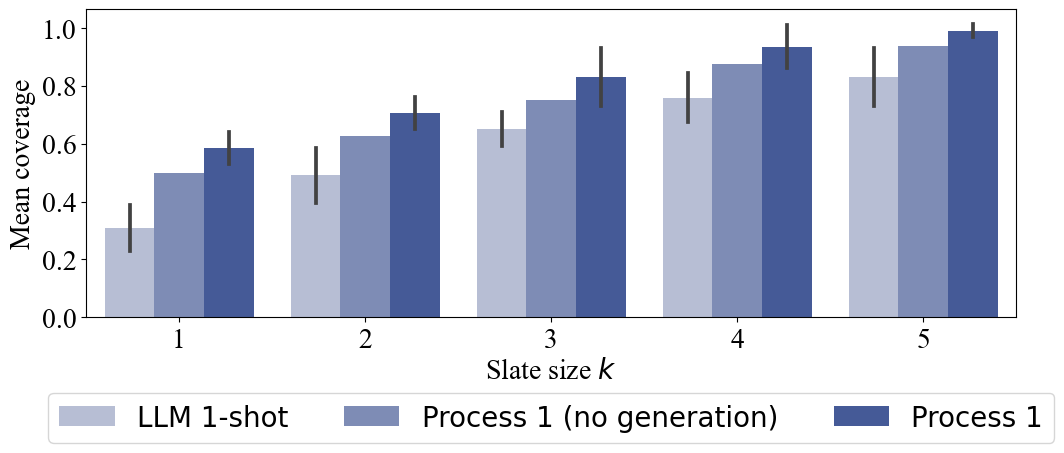

In [13]:
df_results = df_results[df_results["algorithm"].isin(algorithms_to_plot.keys())]


def set_font_properties(ax):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(20)
        item.set_family("Times New Roman")


# Reorder bars
df_results["algorithm_order"] = df_results["algorithm"].map(algorithms_to_plot)
df_results = df_results.sort_values("algorithm_order")

# Set legend labels
df_results["legend_label"] = df_results["algorithm"].map(
    {
        "k_random": "Random slate",
        "k_most_popular": "Top k slate",
        "llm_1shot": "LLM 1-shot",
        "JR_on_human_comments": "Process 1 (no generation)",
        "process_1": "Process 1",
    }
)

num_bars = len(df_results["algorithm"].unique())
num_colors = num_bars + 1  # do to make darker

base_color = "#3753A5"
palette = sns.light_palette(base_color, num_colors)

plt.figure(figsize=(12, 4))
barplot = sns.barplot(
    data=df_results,
    x="k",
    y="coverage",
    hue="legend_label",
    errorbar=("sd", 1),
    palette=palette[-num_bars:],
)

set_font_properties(barplot)

plt.ylabel("Mean coverage", fontsize=20)
plt.xlabel("Slate size $k$", fontsize=20)
legend = plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.20), fontsize=20, ncol=3
)
plt.setp(legend.get_title(), fontsize=20)

plt.savefig("jr_comparisons.pdf", format="pdf", bbox_inches="tight")


plt.show()

# Measure how often JR is violated 

In [14]:
df_jr_violation = df_results.groupby(["algorithm", "k"])["is_jr_violation"].mean()
df_jr_violation

algorithm             k
JR_on_human_comments  1    0.000000
                      2    0.000000
                      3    0.000000
                      4    0.000000
                      5    0.000000
llm_1shot             1    0.000000
                      2    0.000000
                      3    0.000000
                      4    0.071429
                      5    0.000000
process_1             1    0.000000
                      2    0.000000
                      3    0.000000
                      4    0.000000
                      5    0.000000
Name: is_jr_violation, dtype: float64

/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

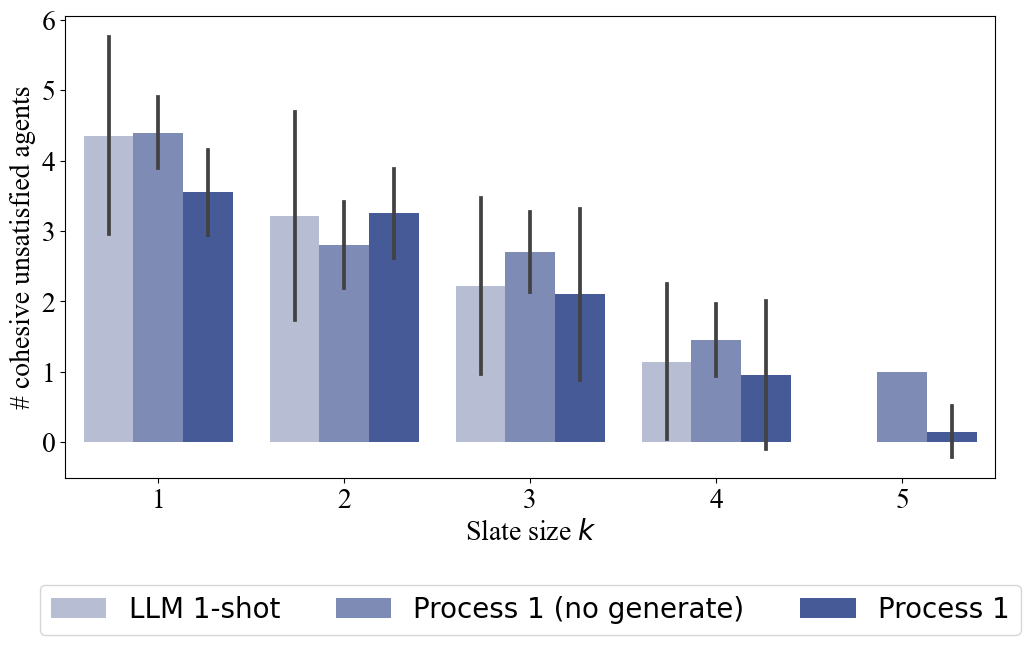

In [15]:
df_results = df_results[df_results["algorithm"].isin(algorithms_to_plot.keys())]


def set_font_properties(ax):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(20)
        item.set_family("Times New Roman")


# Reorder bars
df_results["algorithm_order"] = df_results["algorithm"].map(algorithms_to_plot)
df_results = df_results.sort_values("algorithm_order")

# Set legend labels
df_results["legend_label"] = df_results["algorithm"].map(
    {
        "llm_1shot": "LLM 1-shot",
        "JR_on_human_comments": "Process 1 (no generate)",
        "process_1": "Process 1",
    }
)

num_bars = len(df_results["algorithm"].unique())
num_colors = num_bars + 1  # do to make darker

base_color = "#3753A5"
palette = sns.light_palette(base_color, num_colors)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=df_results,
    x="k",
    y="num_cohesive_unsatisfied_agents",
    hue="legend_label",
    errorbar=("sd", 1),
    palette=palette[-num_bars:],
)


set_font_properties(barplot)

plt.ylabel("# cohesive unsatisfied agents")
plt.xlabel("Slate size $k$")
barplot.legend(title="Algorithm")
legend = plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.20), fontsize=20, ncol=3
)
plt.setp(legend.get_title(), fontsize=20)

plt.savefig("jr_unsatisfied.pdf", format="pdf", bbox_inches="tight")